<a href="https://colab.research.google.com/github/aashnahari/AIResearchColab/blob/main/Copy_of_transformer_asr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Speech Recognition with Transformer

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2021/01/13<br>
**Last modified:** 2021/01/13<br>
**Description:** Training a sequence-to-sequence Transformer for automatic speech recognition.

## Introduction

Automatic speech recognition (ASR) consists of transcribing audio speech segments into text.
ASR can be treated as a sequence-to-sequence problem, where the
audio can be represented as a sequence of feature vectors
and the text as a sequence of characters, words, or subword tokens.

For this demonstration, we will use the LJSpeech dataset from the
[LibriVox](https://librivox.org/) project. It consists of short
audio clips of a single speaker reading passages from 7 non-fiction books.
Our model will be similar to the original Transformer (both encoder and decoder)
as proposed in the paper, "Attention is All You Need".


**References:**

- [Attention is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- [Very Deep Self-Attention Networks for End-to-End Speech Recognition](https://arxiv.org/pdf/1904.13377.pdf)
- [Speech Transformers](https://ieeexplore.ieee.org/document/8462506)
- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)

In [ ]:
#---------------
#      RUN
#---------------
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from functools import partial


In [ ]:
%load_ext tensorboard

## Define the Transformer Input Layer

When processing past target tokens for the decoder, we compute the sum of
position embeddings and token embeddings.

When processing audio features, we apply convolutional layers to downsample
them (via convolution strides) and process local relationships.

In [ ]:
#---------------
#      RUN
#---------------
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=31, maxlen=100, num_hid=32):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 70, strides=1, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 70, strides=1, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 70, strides=1, padding="same", activation="relu"
        )


    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


## Transformer Encoder Layer

In [ ]:
#---------------
#      RUN
#---------------
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Transformer Decoder Layer

In [ ]:
#---------------
#      RUN
#---------------
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


## Complete the Transformer model

Our model takes audio spectrograms as inputs and predicts a sequence of characters.
During training, we give the decoder the target character sequence shifted to the left
as input. During inference, the decoder uses its own past predictions to predict the
next token.

In [ ]:
from tensorflow.python.ops.gen_data_flow_ops import parallel_dynamic_stitch
#---------------
#      RUN
#---------------
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=32,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=31,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.accuracy_metric = keras.metrics.Accuracy()
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)
        self.softmax = tf.keras.layers.Softmax()

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        z = self.classifier(y)
        return z

    @property
    def metrics(self):
        return [self.loss_metric, self.accuracy_metric]

    def predMask(self, preds):
        preds = tf.cast(preds, tf.int32)

        # Create a tensor of the same shape filled with the value to find
        to_find = tf.fill(tf.shape(preds), 0)

        # Create a mask where the tensor is equal to the value to find
        mask = tf.equal(preds, to_find)

        # Get the index of the first occurrence of the value for each row
        indices = tf.argmax(tf.cast(mask, tf.int32), axis=-1)

        indices = tf.cast(indices, tf.int32)

        # Create a sequence of indices for each row
        row_indices = tf.range(tf.shape(preds)[1])

        # Broadcast the row indices to the same shape as the tensor
        row_indices = tf.broadcast_to(row_indices, tf.shape(preds))

        row_indices = tf.cast(row_indices, tf.int32)

        # Create a mask that is 1 for all indices up to the first occurrence for each row
        mask_up_to_first_occurrence = row_indices <= indices[:, None]

        # Cast the boolean mask to integers
        mask_up_to_first_occurrence = tf.cast(mask_up_to_first_occurrence, tf.int32)

        return tf.cast(mask_up_to_first_occurrence,tf.bool)

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        tf.print(target, summarize=-1)
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            predsMaxed = tf.argmax(preds, axis=-1)
            dec_target = tf.cast(dec_target, dtype=tf.int32)
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            targetMask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            predMask = self.predMask(predsMaxed)
            mask = tf.math.logical_or(targetMask, predMask)

            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
            tf.print(preds, summarize=-1)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(dec_target, predsMaxed, sample_weight=mask)
        return {"loss": self.loss_metric.result(), "accuracy": self.accuracy_metric.result()}

    @tf.function
    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        dec_target = tf.cast(dec_target, dtype=tf.int32)
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        predsMaxed = tf.argmax(preds, axis=-1)
        targetMask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        predMask = self.predMask(predsMaxed)
        mask = tf.math.logical_or(targetMask, predMask)

        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(dec_target, predsMaxed, sample_weight=mask)

        return {"loss": self.loss_metric.result(), "accuracy": self.accuracy_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)

        return dec_input




In [ ]:
#---------------
#      RUN
#---------------
from google.colab import drive
drive.mount('/content/my_drive')


Drive already mounted at /content/my_drive; to attempt to forcibly remount, call drive.mount("/content/my_drive", force_remount=True).


## Download the dataset

Note: This requires ~3.6 GB of disk space and
takes ~5 minutes for the extraction of files.

In [ ]:
#---------------
#      RUN
#---------------
def normalizeSentenceDataCube(sentenceDat, singleLetterDat):
    """
    Normalizes the neural data cube by subtracting means and dividing by the standard deviation.
    Important: we use means and standard deviations from the single letter data. This is needed since we
    initialize the HMM parameters using the single letter data, so the sentence data needs to be normalized in the same way.
    """
    neuralCube = sentenceDat['neuralActivityCube'].astype(np.float64)

    #subtract block-specific means from each trial to counteract the slow drift in feature means over time
    for b in range(sentenceDat['blockList'].shape[0]):
        trialsFromThisBlock = np.squeeze(sentenceDat['sentenceBlockNums']==sentenceDat['blockList'][b])
        trialsFromThisBlock = np.argwhere(trialsFromThisBlock)

        closestIdx = np.argmin(np.abs(singleLetterDat['blockList'].astype(np.int32) - sentenceDat['blockList'][b].astype(np.int32)))
        blockMeans = singleLetterDat['meansPerBlock'][closestIdx,:]

        neuralCube[trialsFromThisBlock,:,:] -= blockMeans[np.newaxis,np.newaxis,:]

    #divide by standard deviation to normalize the units
    neuralCube = neuralCube / singleLetterDat['stdAcrossAllData'][np.newaxis,:,:]

    return neuralCube


In [ ]:
#---------------
#      RUN
#---------------
def binTensor(data, binSize):
    """
    A simple utility function to bin a 3d numpy tensor along axis 1 (the time axis here). Data is binned by
    taking the mean across a window of time steps.

    Args:
        data (tensor : B x T x N): A 3d tensor with batch size B, time steps T, and number of features N
        binSize (int): The bin size in # of time steps

    Returns:
        binnedTensor (tensor : B x S x N): A 3d tensor with batch size B, time bins S, and number of features N.
                                           S = floor(T/binSize)
    """

    nBins = np.floor(data.shape[1]/binSize).astype(int)

    sh = np.array(data.shape)
    sh[1] = nBins
    binnedTensor = np.zeros(sh)

    binIdx = np.arange(0,binSize).astype(int)
    for t in range(nBins):
        binnedTensor[:,t,:] = np.mean(data[:,binIdx,:],axis=1)
        binIdx += binSize;

    return binnedTensor




## Preprocess the dataset

In [ ]:
#---------------
#      RUN
#---------------

class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["]", "["]
            + [chr(i + 96) for i in range(1, 27)]
            + [">", ",", "'", "~", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "[" + text + "]"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 28) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 200
vectorizer = VectorizeChar(max_target_len)


def create_tf_dataset(neural_ds, text_ds, bs=4):

    ds = tf.data.Dataset.zip((neural_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds






In [ ]:
x = [ 1, 5, 2, 15, 21, 19, 6, 13, 13, 6, 28, 15, 16, 5, 5, 6, 5, 28,
   2, 15, 5, 28, 10, 28, 17, 22, 13, 13, 6, 5, 28, 16, 22, 21, 28, 14,
  26, 28, 3, 10, 8, 8, 6, 20, 21, 28, 17, 16, 21, 28, 2, 15, 5, 28,
   9, 6, 2, 21, 6, 5, 28, 21, 9, 6, 28, 16, 10, 13, 31]
v = vectorizer.get_vocabulary()
print([v[c] for c in x])


['[', 'd', 'a', 'n', 't', 'r', 'e', 'l', 'l', 'e', '>', 'n', 'o', 'd', 'd', 'e', 'd', '>', 'a', 'n', 'd', '>', 'i', '>', 'p', 'u', 'l', 'l', 'e', 'd', '>', 'o', 'u', 't', '>', 'm', 'y', '>', 'b', 'i', 'g', 'g', 'e', 's', 't', '>', 'p', 'o', 't', '>', 'a', 'n', 'd', '>', 'h', 'e', 'a', 't', 'e', 'd', '>', 't', 'h', 'e', '>', 'o', 'i', 'l', '~']


In [ ]:
vectorizer2 = VectorizeChar(50)
print(vectorizer2("we tried everything else~"))

[1, 24, 6, 28, 21, 19, 10, 6, 5, 28, 6, 23, 6, 19, 26, 21, 9, 10, 15, 8, 28, 6, 13, 20, 6, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import numpy as np
import scipy.io
import scipy.ndimage.filters
import os
import matplotlib
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import tensorflow as tf

sentencesFilenames = ['/content/my_drive/MyDrive/AIResearch/sentencesFile_0.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_1.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_2.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_3.mat','/content/my_drive/MyDrive/AIResearch/sentencesFile_4.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_5.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_6.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_7.mat', '/content/my_drive/MyDrive/AIResearch/sentencesFile_8.mat']

singleLettersFilenames = ['/content/my_drive/MyDrive/AIResearch/singleLettersFile_0.mat','/content/my_drive/MyDrive/AIResearch/singleLettersFile_1.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_2.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_3.mat','/content/my_drive/MyDrive/AIResearch/singleLettersFile_4.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_5.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_6.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_7.mat', '/content/my_drive/MyDrive/AIResearch/singleLettersFile_8.mat']

epochs = 10000
random.seed(73)
randomList = random.choices(range(0, 100), k=90)


def neural_generator(sentenceFiles, slFiles, randomList):


       for i in range(len(sentenceFiles)):
          # Open and read the file
          sentenceFile = sentenceFiles[i]
          slFile = slFiles[i]



          sentenceFile = scipy.io.loadmat(sentenceFile)
          slFile = scipy.io.loadmat(slFile)

          neuralData = normalizeSentenceDataCube(sentenceFile, slFile)
          neuralData = binTensor(neuralData, 2) #RNN BIN SIZE

          timePadding = 7000-len(neuralData[1])
          paddedNeuralData = tf.keras.layers.ZeroPadding1D(padding=(0,timePadding))(neuralData)

          randList = randomList[i*10:(i+1)*10]

          for j in range(len(paddedNeuralData)):
            batch = paddedNeuralData[j]
            if j in randList:
                yield batch, 'val'
            else:
                yield batch, 'train'

neuralData = tf.data.Dataset.from_generator(
    lambda: neural_generator(sentencesFilenames, singleLettersFilenames, randomList),
    output_signature=(
        tf.TensorSpec(shape=(7000,192), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)  # Adjust the shape and dtype as per your data
    ),
)




train_data = neuralData.filter(lambda example, label: label == 'train')
test_data = neuralData.filter(lambda example, label: label == 'val')


def strings_generator(sentenceFiles, randomList):
      for i in range(len(sentenceFiles)):
          file = sentenceFiles[i]
          file = scipy.io.loadmat(file)

          strings = np.array([[item[0] for item in arr] for arr in file['intendedText']])
          strings = strings.flatten()

          randList = randomList[i*10:(i+1)*10]

          for j in range(len(strings)):
            sentence = strings[j]
            sentence = vectorizer(sentence)
            if j in randList:
                yield sentence, 'val'
            else:
                yield sentence, 'train'

strings = tf.data.Dataset.from_generator(
    lambda: strings_generator(sentencesFilenames, randomList),
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)  # Adjust the shape and dtype as per your data
    ),
)




train_strings = strings.filter(lambda example, label: label == 'train')
test_strings = strings.filter(lambda example, label: label == 'val')



train_data = train_data.map(lambda example, label: example)
test_data = test_data.map(lambda example, label: example)
train_strings = train_strings.map(lambda example, label: example)
test_strings = test_strings.map(lambda example, label: example)




In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.9, val_split=0.1, shuffle=False):
    assert (train_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(ds_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [ ]:
ds = create_tf_dataset(train_data, train_strings, bs=3)
val_ds = create_tf_dataset(test_data, test_strings, bs=2)

# dataset = create_tf_dataset(neuralData, strings)


# ds = ds.shuffle(buffer_size=100000000)

numBatch = 845  #845 for full dataset

# ds, val_ds = get_dataset_partitions_tf(dataset, numBatch)

# ds = ds.repeat(epochs)

# ds = ds.batch(3)
# val_ds = val_ds.batch(2)

# del train_data
# del test_data
# del train_strings
# del test_strings


## Callbacks to display predictions

In [ ]:
#---------------
#      RUN
#---------------

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=0, target_end_token_idx=1,
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self,epoch, logs=None):
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_indices = target.astype(int)
            target_text = "".join([self.idx_to_char[_] for _ in target_indices[i, :]])
            prediction = ""
            target_text = target_text[0:target_text.index(self.idx_to_char[self.target_end_token_idx],1)+1]
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break

            target_text = target_text.replace('>',' ')
            prediction = prediction.replace('>',' ')
            print("\n")
            print(f"target:     {target_text.replace('~','.')}")
            print(f"prediction: {prediction}\n")


## Learning rate schedule

In [ ]:
#---------------
#      RUN
#---------------

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = tf.constant(init_lr, dtype=tf.float32)
        self.lr_after_warmup = tf.constant(lr_after_warmup, dtype=tf.float32)
        self.final_lr = tf.constant(final_lr, dtype=tf.float32)
        self.warmup_epochs = tf.constant(warmup_epochs, dtype=tf.float32)
        self.decay_epochs = tf.constant(decay_epochs, dtype=tf.float32)
        self.steps_per_epoch = tf.constant(steps_per_epoch, dtype=tf.float32)


    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            tf.cast(self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,dtype=tf.float32),
        )
        return tf.cast(tf.math.minimum(warmup_lr, decay_lr), dtype=tf.float32)

    def __call__(self, step):
        epoch = (tf.cast(step, tf.float32) // self.steps_per_epoch)-700
        return tf.cast(self.calculate_lr(epoch), dtype=tf.float32)


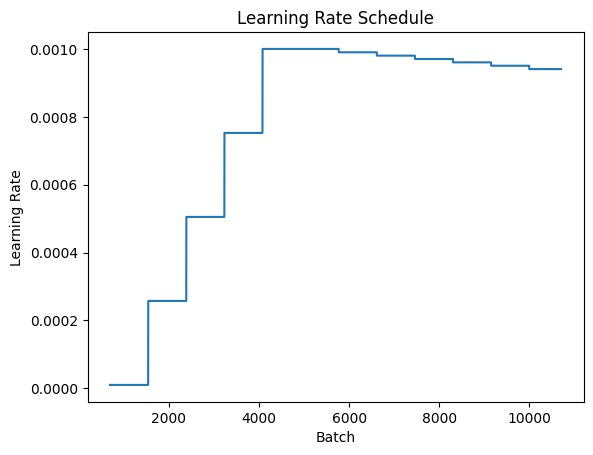

In [ ]:
learning_rate = CustomSchedule(
    init_lr=1e-5,
    lr_after_warmup=1e-3,
    final_lr=1e-5,
    warmup_epochs=5,
    decay_epochs=100,
    steps_per_epoch=numBatch,
)

epochs=10000
lrs = [learning_rate(i+numBatch*700) for i in range(epochs)]


plt.plot(range(700,epochs+700),lrs)
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


In practice, you should train for around 100 epochs or more.

Some of the predicted text at or around epoch 35 may look as follows:
```
target:     <as they sat in the car, frazier asked oswald where his lunch was>
prediction: <as they sat in the car frazier his lunch ware mis lunch was>

target:     <under the entry for may one, nineteen sixty,>
prediction: <under the introus for may monee, nin the sixty,>
```

## Create & train the end-to-end model

In [ ]:
#---------------
#      RUN
#---------------

iterator = iter(val_ds)
batch = next(iterator)


# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=1, target_end_token_idx=0
)

model = Transformer(
    num_hid=32,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=31,
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)




learning_rate = CustomSchedule(
    init_lr=1e-5,
    lr_after_warmup=1e-3,
    final_lr=1e-5,
    warmup_epochs=5,
    decay_epochs=100,
    steps_per_epoch=numBatch,
)



optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[tf.keras.metrics.CategoricalAccuracy()])

checkpoint_filepath = os.path.join('/content/my_drive/MyDrive/AIResearch/outputDir','ckpt','weights.ckpt')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

log_dir = "/content/my_drive/MyDrive/AIResearch/outputDir-logs/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#model.evaluate(x=ds,callbacks=[display_cb], return_dict=True)
model.load_weights(checkpoint_filepath)
model.fit(ds, validation_data=val_ds, callbacks=[display_cb, model_checkpoint_callback,tensorboard_callback], epochs=epochs, initial_epoch=700)




Streaming output truncated to the last 5000 lines.
  [17233496 -17158664 -16671533 -14763517 -15541616 -16142549 -16798178 -15198936 -15252889 -16286247 -16423730 -14860345 -15235816 -16139381 -15581691 -16366693 -16389004 -15025450 -14947937 -16434652 -16122802 -16562406 -15855020 -14694198 -15707328 -14729448 -15666890 -14776265 -17000970 -13458765 -13981752]
  [17233496 -17158664 -16671533 -14763517 -15541615 -16142549 -16798178 -15198936 -15252889 -16286247 -16423730 -14860344 -15235815 -16139381 -15581692 -16366694 -16389005 -15025450 -14947935 -16434652 -16122802 -16562405 -15855021 -14694198 -15707329 -14729448 -15666890 -14776265 -17000972 -13458765 -13981752]
  [17233496 -17158664 -16671533 -14763517 -15541615 -16142549 -16798178 -15198936 -15252888 -16286247 -16423730 -14860344 -15235814 -16139381 -15581692 -16366694 -16389005 -15025450 -14947935 -16434652 -16122802 -16562405 -15855020 -14694198 -15707328 -14729448 -15666889 -14776265 -17000972 -13458765 -13981752]
  [1723349

KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir /content/my_drive/MyDrive/AIResearch/outputDir-logs/logs/fit